## One state variable
### Consumption-Based Model – Time-Varying Diffusion
The state variable is now associated with the consumption diffusion unlike example in which it was associated with consumption drift. Given a CRRA utility function the SDF process can be computed, inserted in the pricing equation and then solved using a Feynman-Kac formula. The modified state variable follows the process:

$$
\mathrm{d}\bar{x}_t=\big(-\log\phi(x_0-\bar{x}_t) +\rho_{cx}\sigma_{ct}\sigma_x\big)\mathrm{d}t+\sigma_{x}\mathrm{d}W_{xt}
$$

While the state variable is not modified when there is no correlation between the process for consumption and the process for the state variable:

$$
\mathrm{d}x_t=-\log\phi(x_0-x_t)\mathrm{d}t+\sigma_{x}\mathrm{d}W_{xt}
$$

In order to get the price of the zero-coupon security a process for the integral of the short-term rate will also be needed:

$$
\mathrm{d}A = r(\bar{x}_t)\mathrm{d}t
$$

##### Import the packages

In [19]:
import SDFFinance as sdf
import StochasticDiffEq as sde # this is needed in order to specify the algorithm

#### Define the parameters

In [20]:
cs = (
    phi = 0.92, # mean reversion
    x0 = 0.0, # long-run mean
    rho = 0.01, # time preference parameter
    gamma = 2, # risk aversion
    muc0 = 0.005, # mean of consumption drift
    sigmac0 = 0.04, # consumption diffusion ###- higher compared to example 1
    sigmax = 0.5, # state variable diffusion ###- higher compared to example 1
    rhocx = -0.3 # correlation between consumption and state variable
);

#### Drift and Diffusion of the processes
I also include the unmodified process which will correspond to "risk-neutral pricing". By comparing normal pricing with risk-neutral pricing it is possible to compute excess returns.

In [21]:
###- now consumption diffusion is a non-linear function of the state, 
###- given that it needs to be positive.
###- I use this function because the simple exponential can get too high for some samples.
sigmac(x,c) = c.sigmac0*(x<0 ? 2/(1+exp(-2x)) : 4/(1+exp(-x))-1) 
mu0(x,c) = -log(c.phi)*(c.x0-x) # drift of unmodified state
sigma0(x,c) = c.sigmax; # diffusion of unmodified state
mu(x,c) = mu0(x,c)-c.rhocx*c.gamma*sigmac(x,c)*sigma0(x,c) # drift of unmodified state
sigma(x,c) = sigma0(x,c); # diffusion of unmodified state

#### Short-term rate function

In [22]:
r(x,c) = c.rho+c.gamma*c.muc0-c.gamma^2*sigmac(x,c)^2/2;
r(x) = r(x,cs);

#### Define setup consistent with SDE solution in Julia

In [23]:
function drift(du,u,p,t,c)
    du[1] = mu0(u[1],c)
    du[2] = mu(u[2],c)
    du[3] = r(u[1],c)
    du[4] = r(u[2],c)
end
drift(du,u,p,t) = drift(du,u,p,t,cs);
function diffusion(du,u,p,t,c)
    du[1] = sigma0(u[1],c)
    du[2] = sigma(u[2],c)
    du[3] = 0.0
    du[4] = 0.0
end
diffusion(du,u,p,t) = diffusion(du,u,p,t,cs);

#### Define the Problem and SolutionSettings variables

In [24]:
prob = sdf.Problem(drift=drift,diffusion=diffusion,numNoiseVariables=1,outVariables=[3,4],
terminalFunction=(ik, x, y, z) -> exp(-x));
xRange = -2.0:0.4:2.0;
sett = sdf.SolutionSettings(xRanges=[xRange,], initialValues=[[x, x, 0.0, 0.0] for x in xRange], 
algorithm=sde.LambaEM(), pathsPerInitialValue=20000, tRange=0.0:1.0:10.0);


#### Solve Problem and Define Yield

In [25]:
((bondPriceRiskNeutral,bondPrice),) = sdf.solve(prob, sett);
yld(t,x) = -log(bondPrice(t,x))/t;
yldRiskNeutral(t,x) = -log(bondPriceRiskNeutral(t,x))/t;

#### Plot the yield

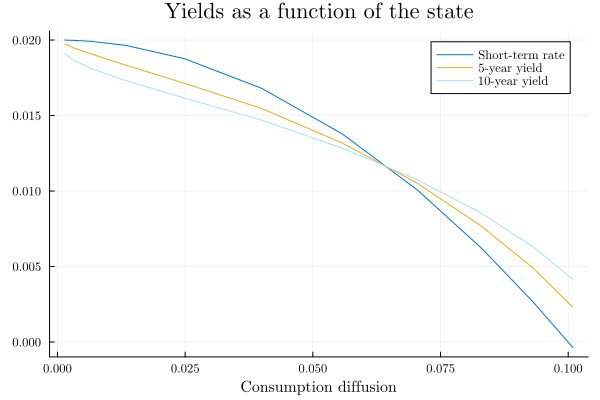

In [26]:
# colors: "#0075d6", "#edad14", "#a3e3ff", "#9c0000"
import Plots as plt
plt.default(titlefont= (14,"Computer Modern"),legendfont=(8,"Computer Modern"),
    tickfont=(8,"Computer Modern"),guidefont=(10,"Computer Modern"))
plt.plot(xRange .|>x->sigmac(x,cs), xRange .|> x->r(x), title="Yields as a function of the state",
    xlabel="Consumption diffusion",label="Short-term rate",color="#0075d6")
plt.plot!(xRange .|>x->sigmac(x,cs), yld.(5.0, xRange), label="5-year yield",color= "#edad14")
plt.plot!(xRange .|>x->sigmac(x,cs), yld.(10.0, xRange), label="10-year yield",color="#a3e3ff")

#### Plot the term premium

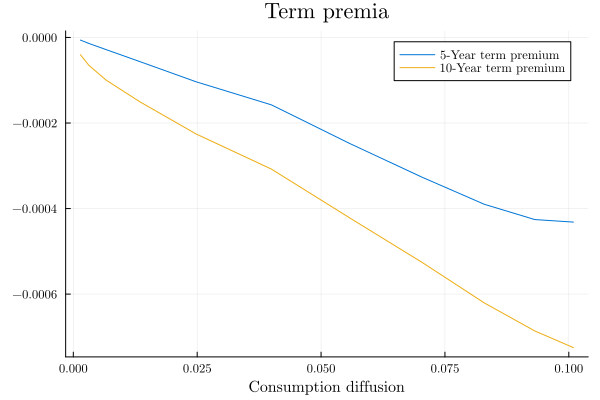

In [27]:
plt.plot(xRange .|>x->sigmac(x,cs), yld.(5.0, xRange) .- yldRiskNeutral.(5.0, xRange),title="Term premia",
    xlabel="Consumption diffusion",label="5-Year term premium",color="#0075d6")
plt.plot!(xRange .|>x->sigmac(x,cs), yld.(10.0, xRange) .- yldRiskNeutral.(10.0, xRange),
    label="10-Year term premium",color="#edad14")


This shows that term premia are state-dependent when consumption diffusion is time-varying. They can also get larger in absolute value when consumption volatility is relatively high.